# Import Packages

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

from anaysis.src.bivariate_analysis import BivariateAnalyzer, CategoricalVsNumericalAnalysis, StoreItemSalesBivariateAnalysis
from anaysis.src.feature_engineering import FeatureEngineer, DateFeatureEngineeringStrategy, FeatureEngineeringStrategy
from anaysis.src.seasonal_trend_analysis import SeasonalTrendAnalyzer, DateFeaturesSeasonalTrendAnalysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

# Loading data

In [2]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
data = pd.concat([train_data, test_data], sort=False)

# Exploratory Data Analysis
## Date Ranges

In [3]:
print(f"Min Date: {data['date'].min()}")
print(f"Max Date: {data['date'].max()}")

Min Date: 2013-01-01
Max Date: 2018-03-31


#### Key Observations
- The data spans from January 1, 2013 to March 31, 2018.
- The range covers approximately 5+ years, suggesting a relatively long observation period.

## Shape of DataFrame

In [4]:
print(data.shape)

(958000, 5)


#### Key Observations
- The dataset comprises 958,000 records and 5 features, providing a substantial volume of data for analysis. Each record represents an observation, and the 5 features offer key attributes to explore relationships, trends, and patterns within the data

## Data Types

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    958000 non-null  object 
 1   store   958000 non-null  int64  
 2   item    958000 non-null  int64  
 3   sales   913000 non-null  float64
 4   id      45000 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 43.9+ MB
None


#### Key Insights
- The `date` column is currently of object type and should be converted to datetime for proper analysis.

## Data Type Conversion

In [6]:
data['date'] = pd.to_datetime(data['date'])

## Unique values for each feature

In [7]:
data.nunique()

date      1916
store       10
item        50
sales      213
id       45000
dtype: int64

#### Key Observations
- The dataset comprises 1,916 unique dates, 10 distinct stores, 50 unique items, and 213 unique sales values. This rich structure enables a detailed analysis of sales patterns over time, item performance across different stores, and trends in sales values.

## Observing first and last 5 entries

In [8]:
print(data.head())
print(data.tail())

        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0


#### Key Insights
- Sales Column: `NaN` values at the end represent missing target values in the test dataset, which need to be predicted.
- ID Column: Missing `id` values in the train set are expected since they are not required for model training.
## Descriptive Statistics

In [9]:
print(data.describe().T)

          count                           mean                  min                  25%                  50%                  75%                  max           std
date     958000  2015-08-16 11:59:59.999999744  2013-01-01 00:00:00  2014-04-24 18:00:00  2015-08-16 12:00:00  2016-12-07 06:00:00  2018-03-31 00:00:00           NaN
store  958000.0                            5.5                  1.0                  3.0                  5.5                  8.0                 10.0      2.872283
item   958000.0                           25.5                  1.0                 13.0                 25.5                 38.0                 50.0     14.430877
sales  913000.0                      52.250287                  0.0                 30.0                 47.0                 70.0                231.0     28.801144
id      45000.0                        22499.5                  0.0             11249.75              22499.5             33749.25              44999.0  12990.525394


#### Key Insights
- **Missing Sales Data:** The discrepancy in sales count (913,000 vs. 958,000) confirms missing sales values in the test dataset.
- **Sales Distribution:** Sales are right-skewed, as the mean (52.25) is greater than the median (47.0). This suggests that while most sales hover around 30–70, there are some higher sales values (up to 231) contributing to the skew.
- **Even Distribution of Stores and Items:** Both store and item values are evenly spread across their respective ranges, which is useful for balanced analysis.

## Sales by Store

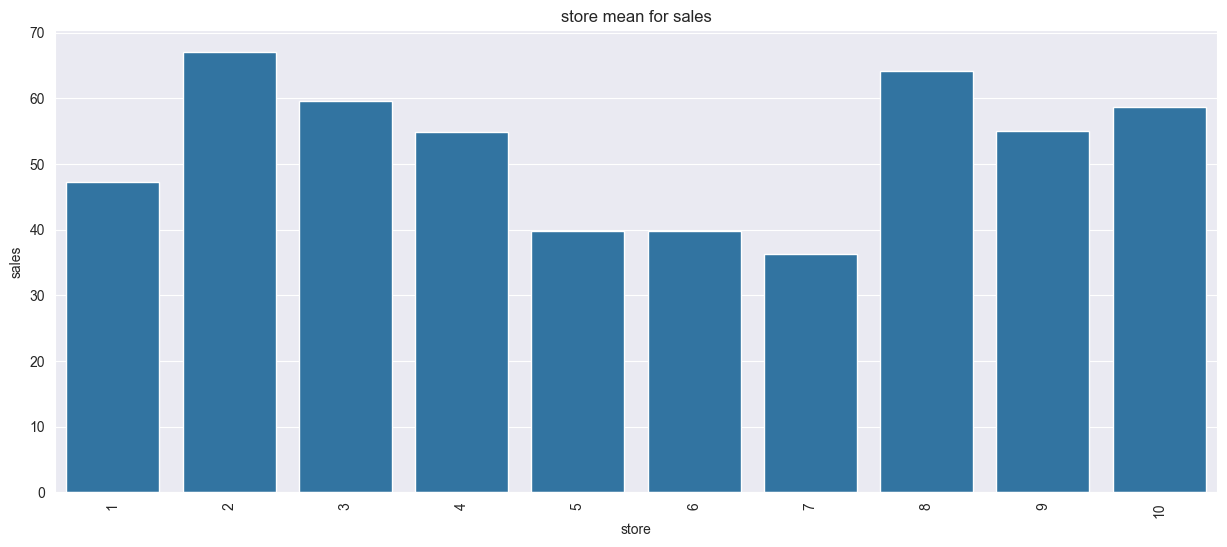

In [10]:
bivariate_Analyzer = BivariateAnalyzer(CategoricalVsNumericalAnalysis())
bivariate_Analyzer.analyze(data, 'store', 'sales')

#### Key Insights
- Stores 2, 3 and, 8 exhibit the highest average sales, ranging between 60 and 70.
- These stores likely benefit from factors like higher customer traffic, effective inventory management, or strong demand for popular items.
- Stores 5, 6, and 7 have the lowest average sales, ranging between 35 and 40.
- These stores may face challenges such as low demand, inventory issues, or reduced customer engagement.
- Stores 1, 4, and 9 fall in the middle range, with average sales between 45 and 55.
- These stores show stable performance but have room for improvement through targeted strategies such as better product placement and promotions.
- The variability in store performance highlights significant differences in demand or operations across locations.
- High-performing stores drive a disproportionate share of total sales, while low-performing stores pull down overall averages.

## Sales by Item

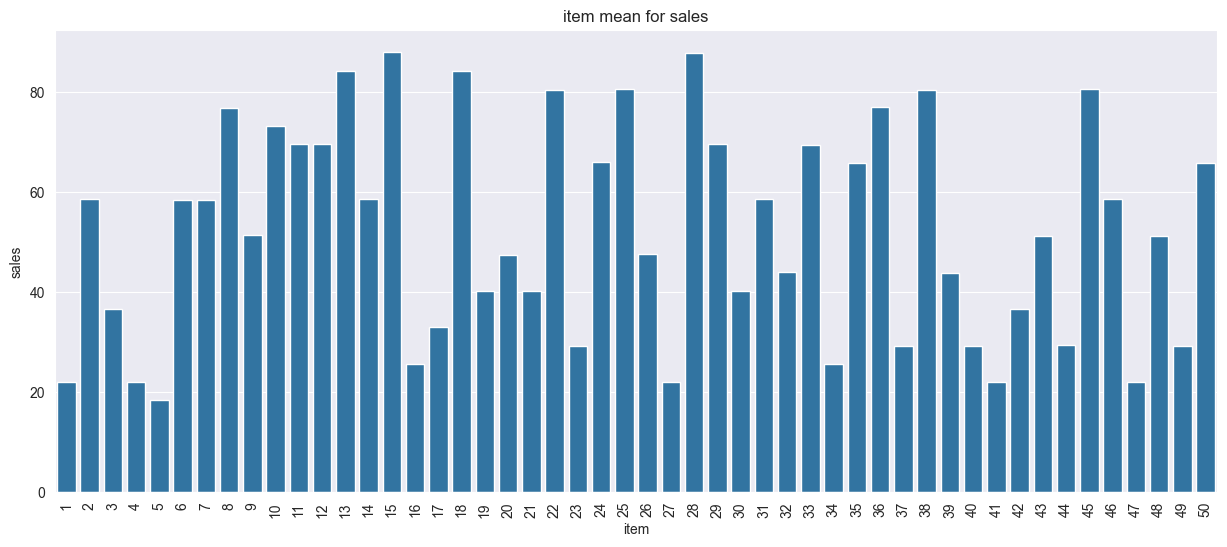

In [11]:
bivariate_analyzer = BivariateAnalyzer(CategoricalVsNumericalAnalysis())
bivariate_analyzer.analyze(data, 'item', 'sales')

#### Key Insights
- Items 13, 15, 18, 28, 36, and 45 consistently show high average sales across all stores.
- These items are universally popular and should be prioritized for inventory management, promotions, and marketing efforts.
- Items 1, 4, 5, 16, 27, 34, and 41 have consistently low average sales across stores.
- These products may require reassessment for removal, discounting, or strategic adjustments to improve visibility and demand.
- Items like 6-10, 14, 21-25, and 42-50 exhibit moderate variability in sales.
- Their performance may be store-specific or seasonal, requiring deeper analysis to identify opportunities for improvement.
- A small group of items contributes disproportionately to total sales, aligning with the Pareto principle (80/20 rule).
- While high-performing items succeed across most stores, localized variations exist, suggesting the need for tailored strategies based on store performance.

# Sales by Store and Item

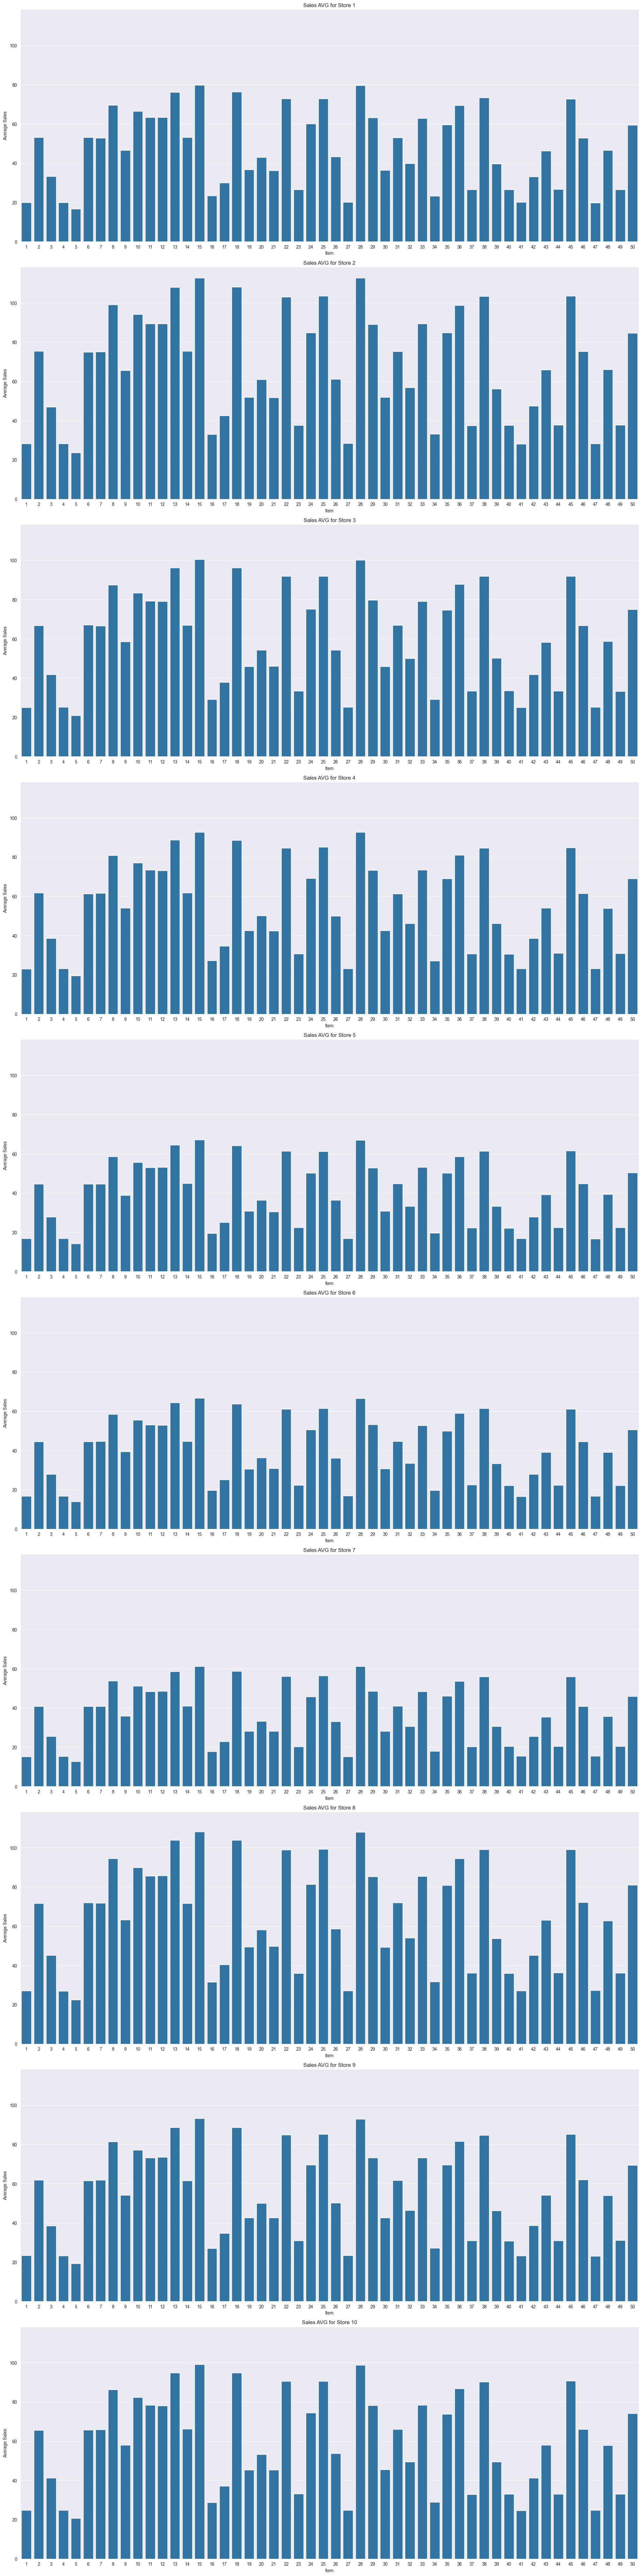

In [12]:
bivariate_analyzer = BivariateAnalyzer(StoreItemSalesBivariateAnalysis())
bivariate_analyzer.analyze(data, 'store', 'item')

#### Key Insights
- Items 13, 15, 28, and 45 are the most consistently successful products across stores.
- Items 1, 3, 4, and 27 are universally weak, with minor exceptions in isolated stores.
- While some items excel everywhere, localized variations exist, suggesting that customer preferences or store-specific conditions play a role in item performance.

# Feature Engineering

In [13]:
feature_engineer = FeatureEngineer(DateFeatureEngineeringStrategy())
data = feature_engineer.engineer_features(data)
data.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,day_of_week,year,is_weekend,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,5,2013,1,0,0


# Post Data Preparation Exploratory Data Analysis
## Store Item Sales by Month

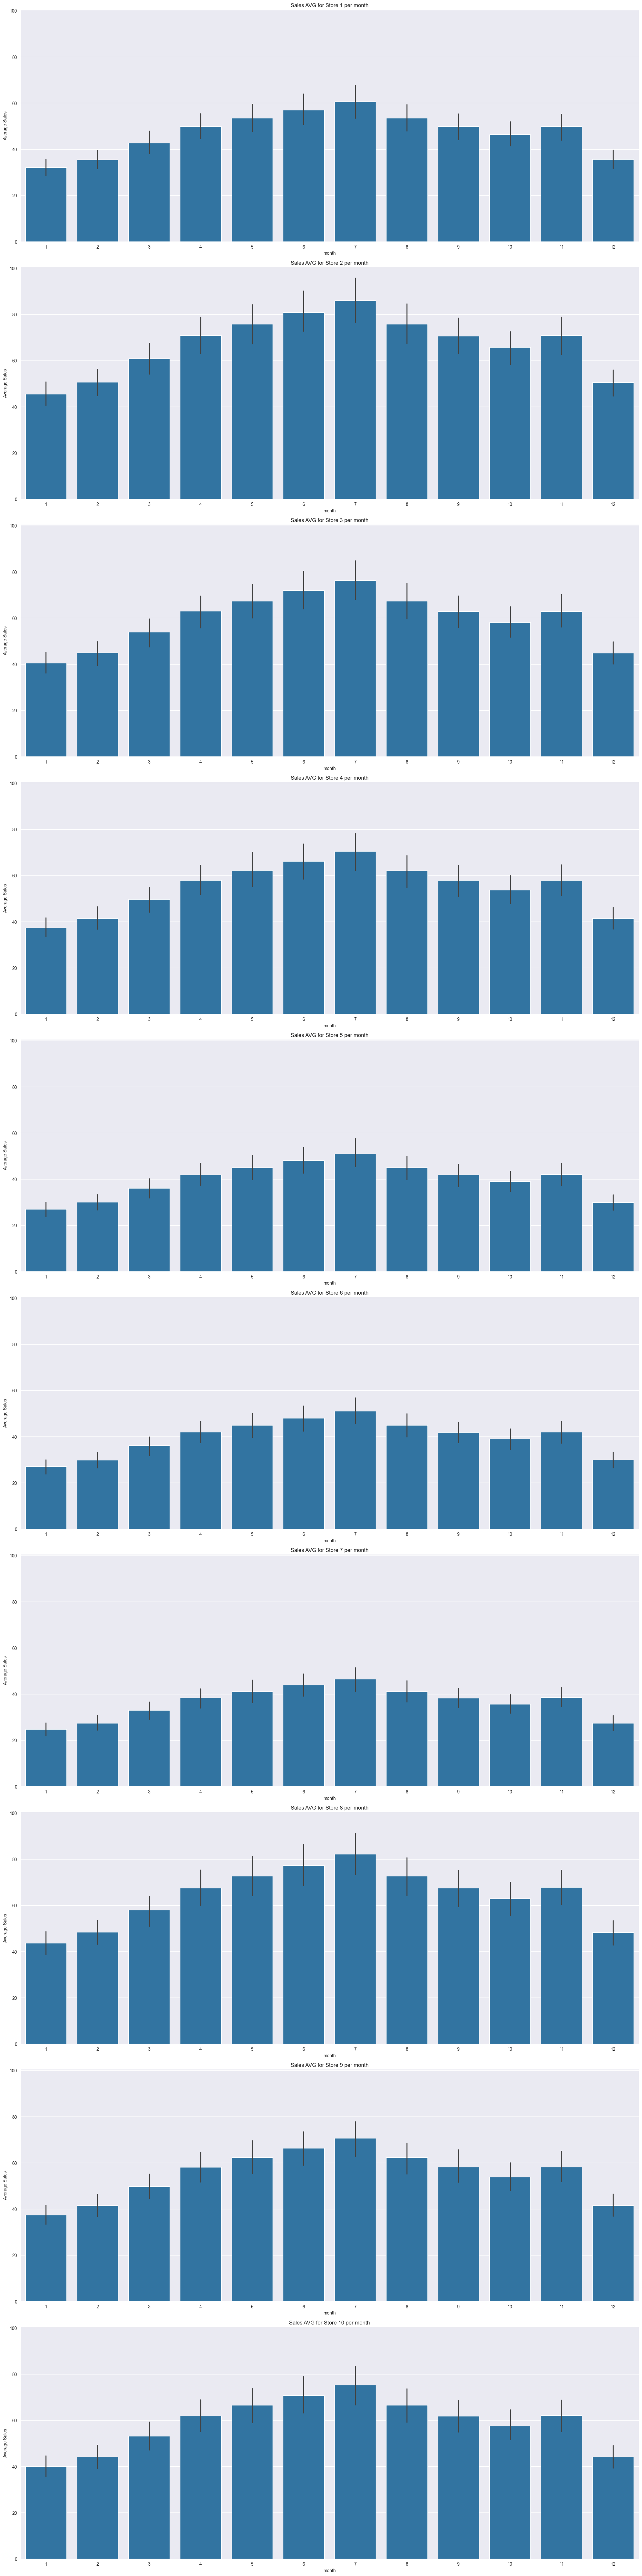

In [14]:
seasonal_trend_analyzer = SeasonalTrendAnalyzer(DateFeaturesSeasonalTrendAnalysis())
seasonal_trend_analyzer.analyze(data, 'month')

#### Key Insights
- Sales tend to peak around the middle months of the year (e.g., months 6, 7, and 8) across all stores.
- This indicates a seasonal trend, with higher demand likely occurring in the summer months.
- Months 1, 2, and 12 consistently show lower average sales across all stores.
- These months correspond to the beginning and end of the year, suggesting potential factors like reduced consumer activity after holidays or seasonal downturns.
- Stores 2 and 8 exhibit the strongest sales peaks during the mid-year months (months 6–8), suggesting higher demand in these locations during that period.
- Stores 5 and 6 display flatter trends, indicating less monthly variation and potentially more consistent but lower overall sales.
- While mid-year months (6–8) are strong performers universally, the magnitude of sales varies by store:
    - Stores 2, 3, 8, and 10 have noticeably higher peaks.
    - Stores 5, 6, and 7 show smaller peaks and generally lower average sales.


## Store Item Sales by Day of Month

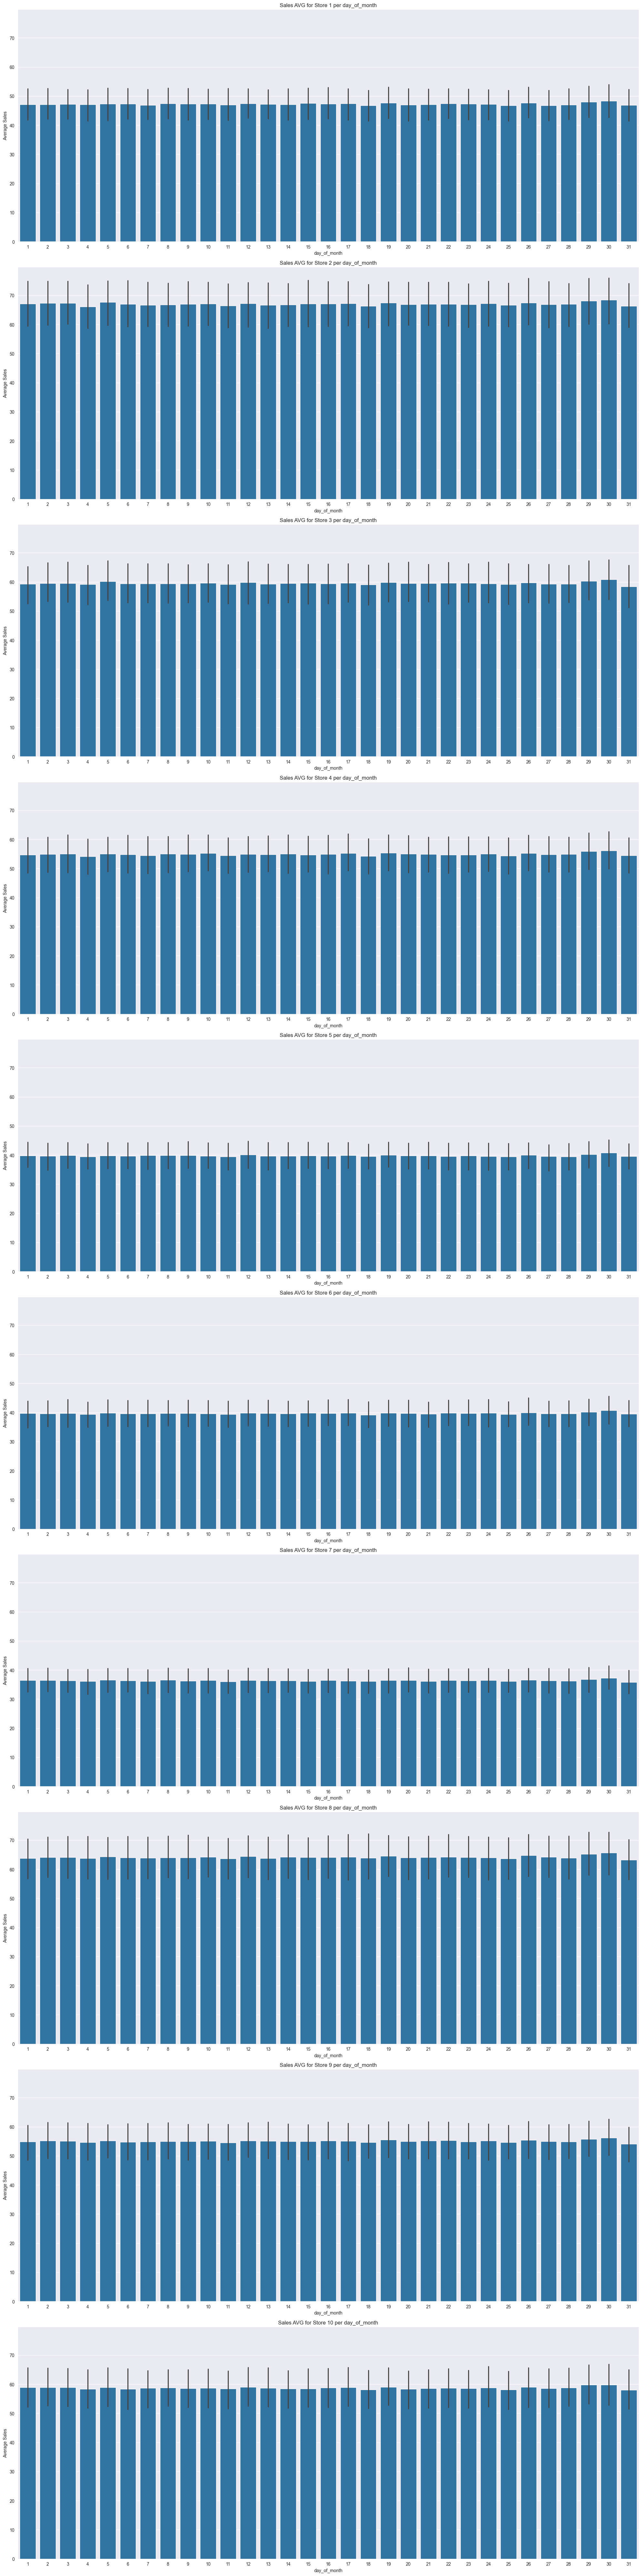

In [15]:
seasonal_trend_analyzer.analyze(data, 'day_of_month')

#### Key Insights
- Sales remain steady throughout the month for all stores, with no significant peaks or drops on specific days.
- This suggests that there is no day-of-the-month effect influencing customer purchasing behavior.
- Stores 8, 9, and 10 consistently have higher daily average sales (in the range of 55–65).
- Store 8, in particular, stands out with averages near 65 and slightly higher variability, indicating strong overall demand.
- Store 7 has the lowest average daily sales, around 35–40, compared to other stores.
- This highlights a need for targeted interventions such as promotions, product optimization, or localized marketing strategies.
- Error bars indicate small day-to-day variability, meaning that sales patterns are relatively stable across all days of the month.
- This stability reflects consistent consumer behavior, with no evident outliers or spikes on specific days.
- Stores 1–6 exhibit average daily sales in the 40–55 range.
- These stores have steady performance but lack any standout days, suggesting opportunities for improvement through campaigns like end-of-month or mid-month promotions.


## Store Item Sales by Day of Week

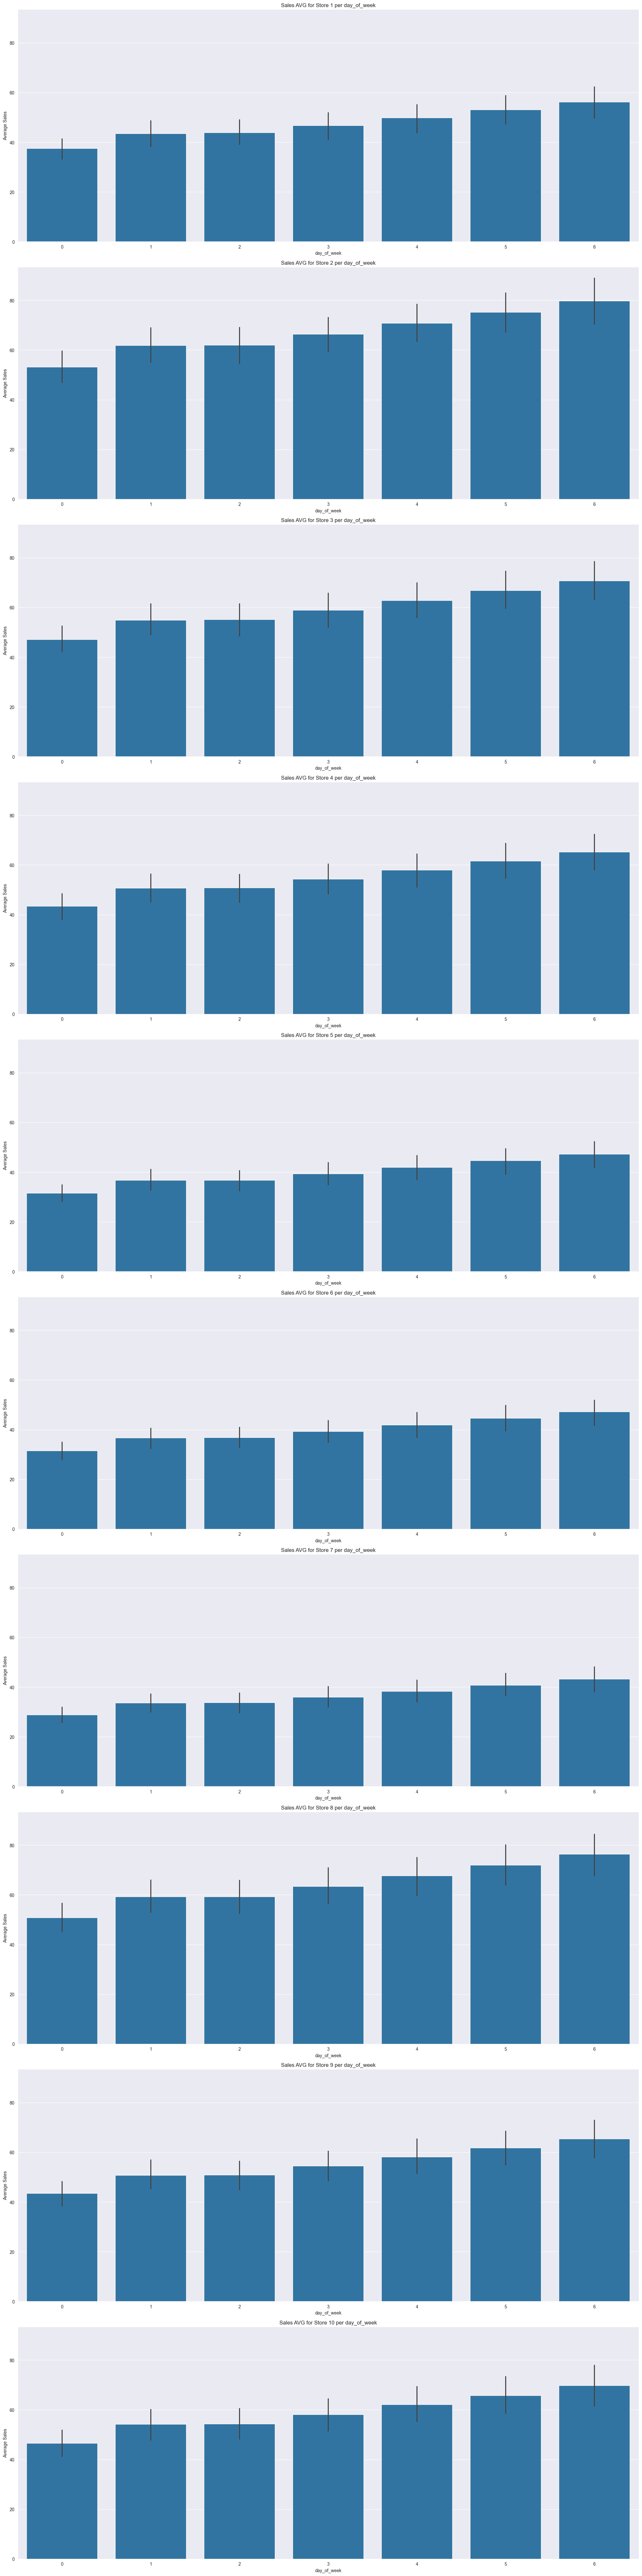

In [16]:
seasonal_trend_analyzer.analyze(data, 'day_of_week')

#### Key Insights
- Sales consistently increase as the week progresses, peaking on Days 5 and 6 (likely Friday and Saturday).
- Sales are lowest on Day 0 (likely Sunday), indicating reduced consumer activity at the start of the week.
- Days 5 and 6 are the best-performing days across all stores, suggesting consumers prefer shopping toward the end of the week, possibly due to convenience or preparation for weekends.
- Day 0 (Sunday) shows the lowest sales across all stores, highlighting a consistent dip in demand at the beginning of the week.
- Stores 2, 8, 9, and 10 have higher overall sales throughout the week, with significant spikes on Days 5 and 6 (reaching 70–80 in average sales).
- Stores 5, 6, and 7 display consistently lower sales (30–40 range) across all days, with smaller increases toward the end of the week.
- Stores 3 and 4 show moderate performance with noticeable growth toward the weekend but lack the high peaks seen in top-performing stores.
- Sales variability (as seen from error bars) is generally low across the week, indicating stable patterns with predictable increases toward the weekend.

## Store Item Sales by Weekend

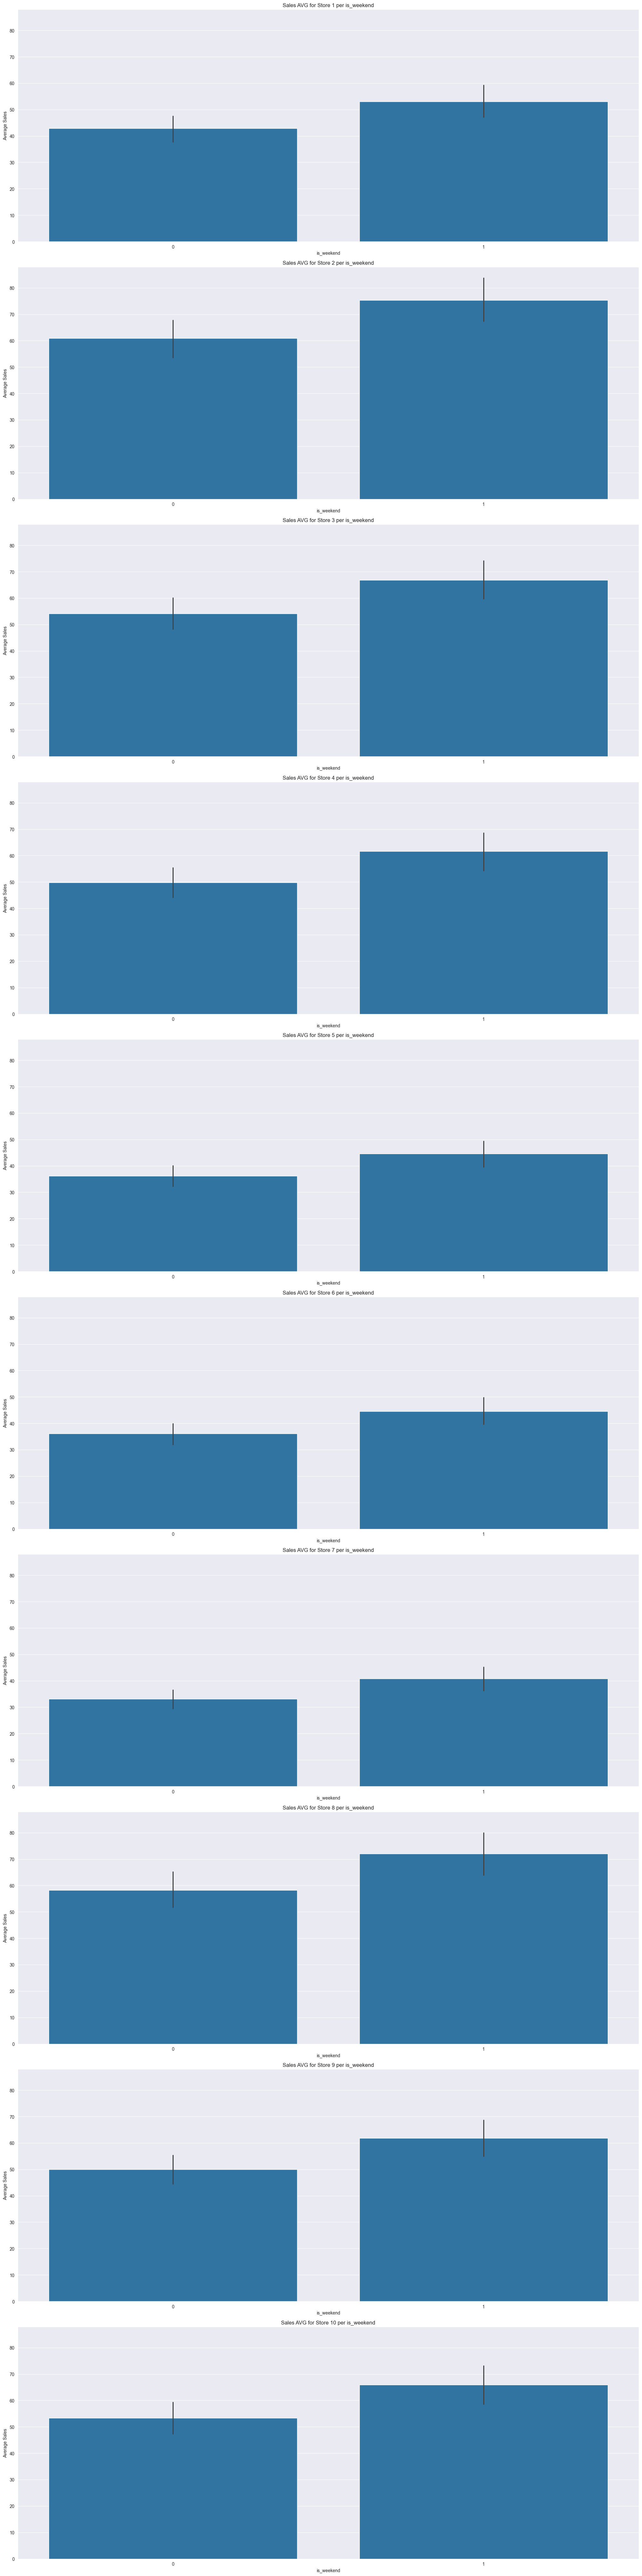

In [17]:
seasonal_trend_analyzer.analyze(data, 'is_weekend')

#### Key Insights
- Across all stores, weekend sales (denoted by is_weekend = 1) are consistently higher than weekday sales.
- The difference between weekend and weekday sales is most prominent in stores like Store 2, Store 8, and Store 10, where weekend averages exceed weekdays significantly.
- Weekday sales (denoted by is_weekend = 0) are noticeably lower across all stores.
- The gap between weekday and weekend performance highlights reduced consumer activity during weekdays.
- Stores 2, 8, 9, and 10 show the highest weekend averages (around 70–80), emphasizing their strong performance during weekends.
- Stores 5, 6, and 7 exhibit smaller differences between weekday and weekend sales, with relatively lower averages (~35–45).
- The error bars for weekend sales are slightly larger, indicating greater variability during weekends, likely due to fluctuating consumer traffic.

## Store Item Sales by Month Start

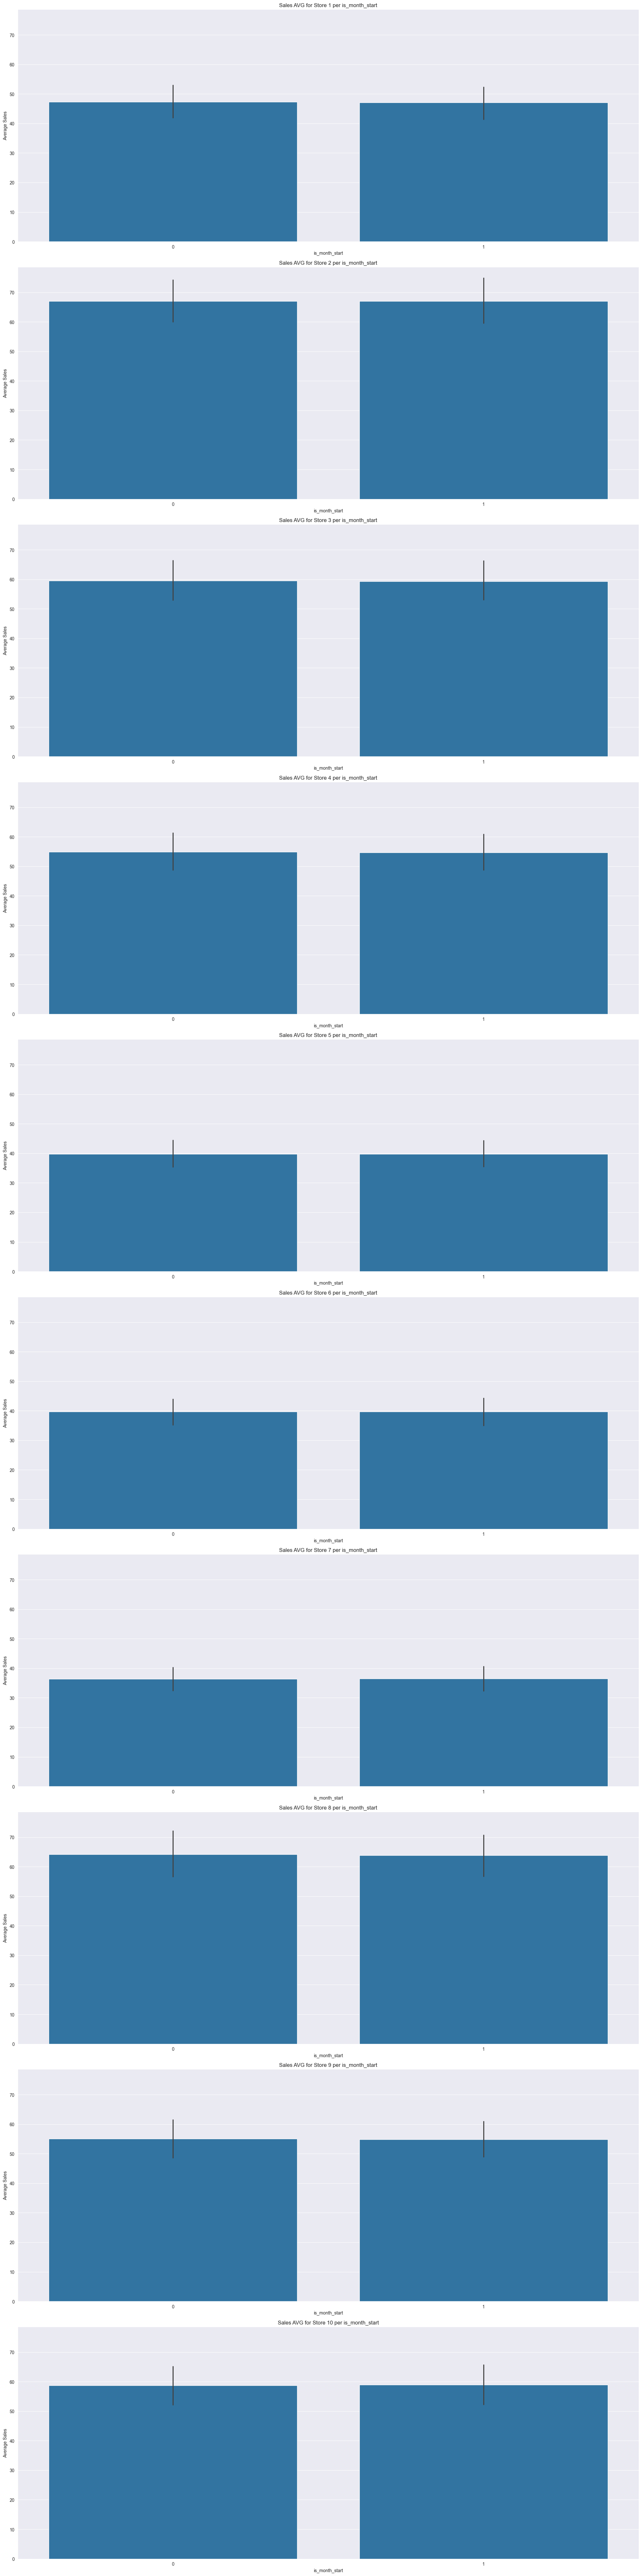

In [18]:
seasonal_trend_analyzer.analyze(data, 'is_month_start')

#### Key Insights
- Across all stores, there is no significant difference in average sales between the start of the month (is_month_start = 1) and other days (is_month_start = 0).
- The bar heights are nearly identical, indicating that consumer behavior does not change notably at the start of the month.
- Store 2 and Store 8 show slightly higher average sales during the rest of month compared to the month start. However, the difference is small and not statistically significant given the overlapping error bars.
- Other stores, such as Stores 5, 6, and 7, exhibit consistent average sales regardless of the month start.
- The error bars for most stores are small and consistent, indicating stable sales patterns.
- There is no clear evidence of spikes or drops in variability around month start.
- Stores like Store 2, Store 8, and Store 10 maintain relatively higher average sales overall, regardless of the month start.
- Store 7 remains a consistent underperformer, showing lower average sales across both month start and non-month start periods.

## Store Item Sales by Month End

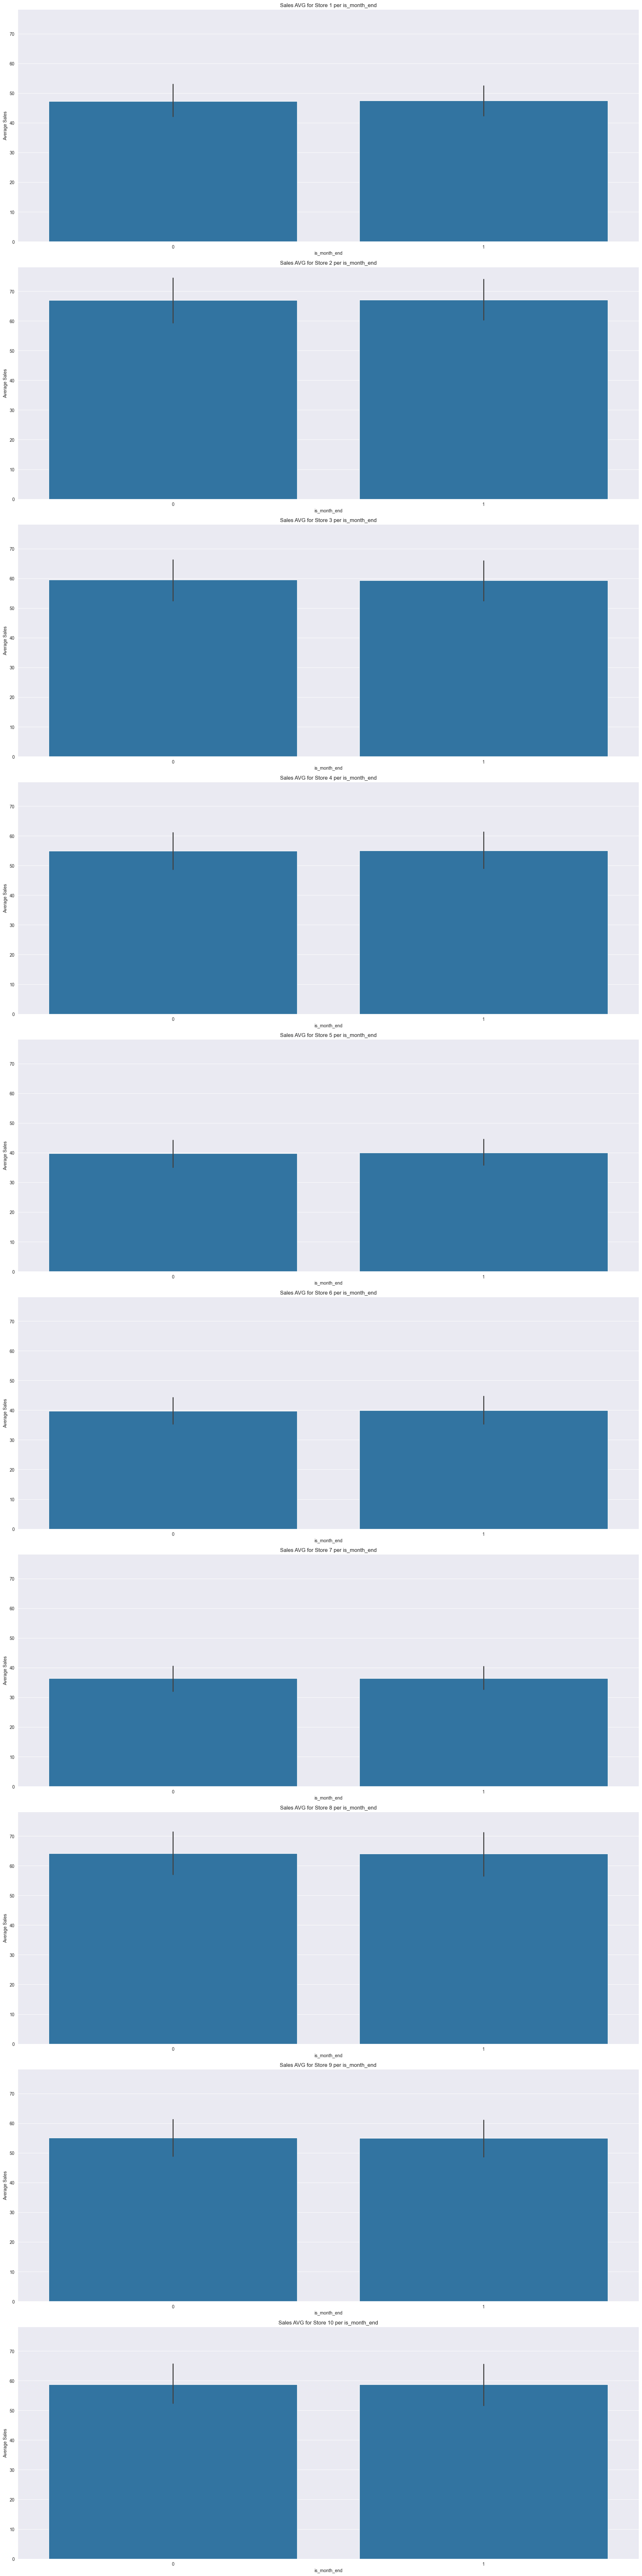

In [19]:
seasonal_trend_analyzer.analyze(data, 'is_month_end')

#### Key Insights
- Across all stores, there is no substantial variability between month-end (is_month_end = 1) and non-month-end (is_month_end = 0) periods. The average sales are fairly stable across both conditions.
- These stores show very minimal differences in average sales at month-end versus non-month-end days. The confidence intervals overlap significantly, indicating no statistically significant difference.
- Stores 2, 8, 9 and, 10, have slightly higher average sales compared to others, but variability remains minimal.
- Store 2 and Store 8, generally report higher average sales overall, but no clear spike is observed at month-end.
- Stores 5, 6 and, 7 report consistently lower sales compared to others and show no increase at month-end.
- Sales remain consistent throughout the month, with no significant month-end effect across all stores. While average sales may differ by store, variability across month-end and non-month-end days is negligible.

## Store Item Sales by Year

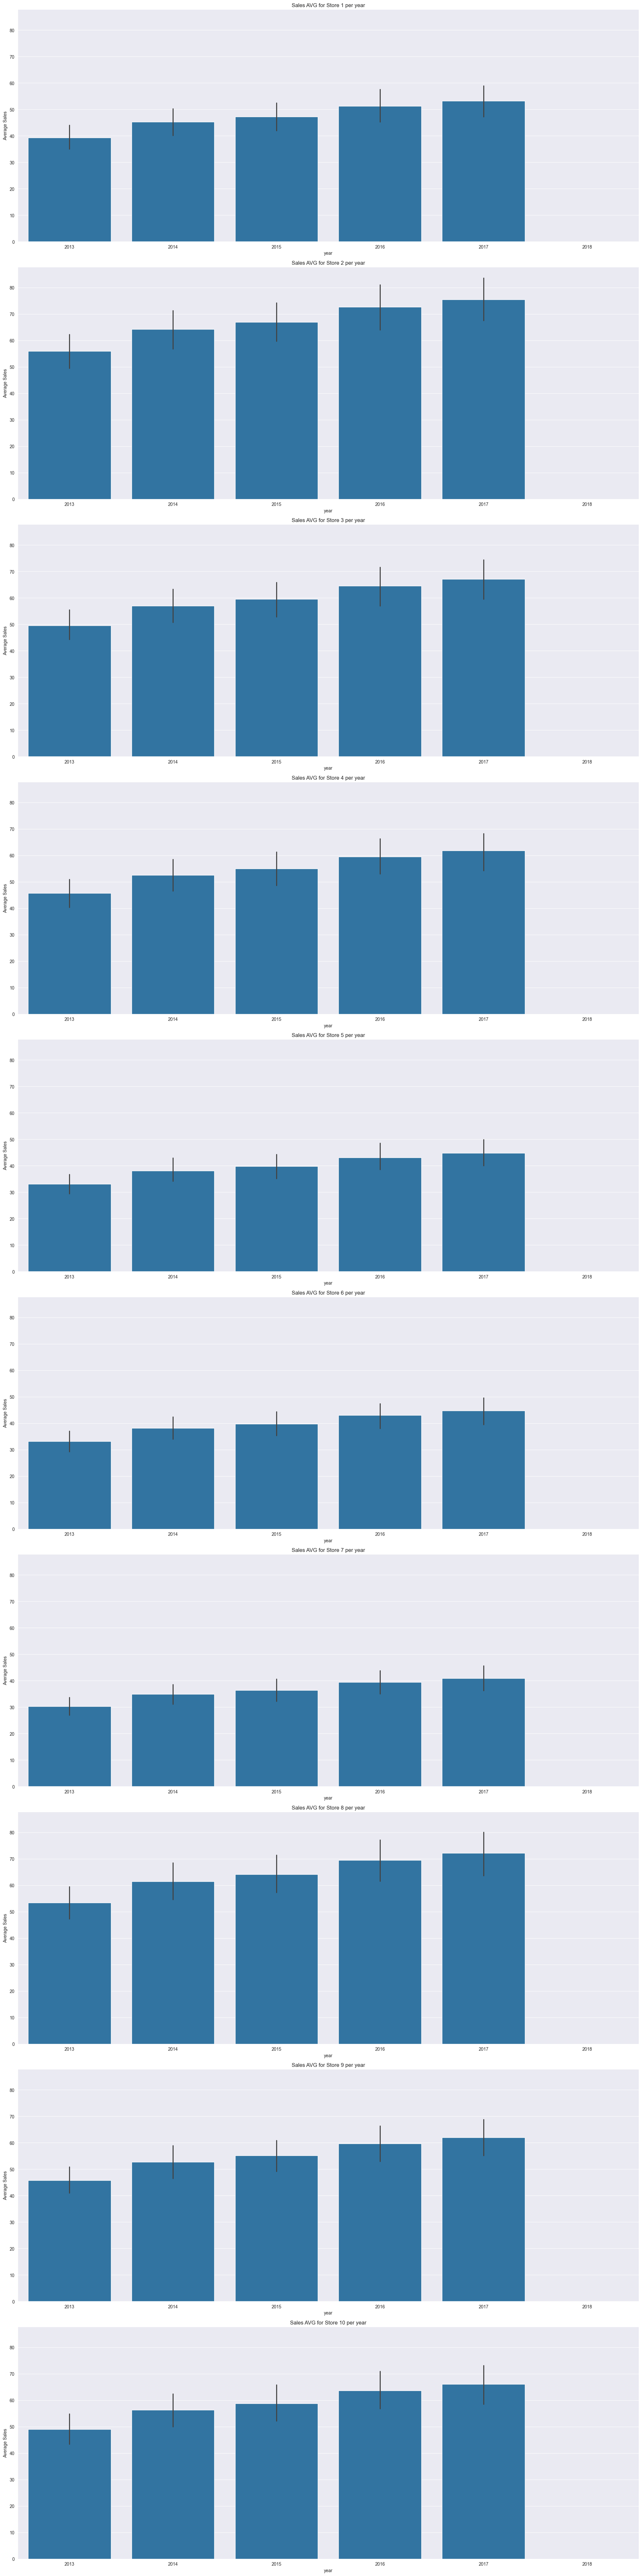

In [20]:
seasonal_trend_analyzer.analyze(data, 'year')

#### Key Insights
- For all stores (1 to 10), sales show a consistent upward trend from 2013 to 2017.
- Sales gradually increase year over year, suggesting overall growth in performance across the stores.
- Each store exhibits a noticeable increase in average sales between 2013 and 2017, with slight differences in the rate of growth.
- Store 8 and Store 2 show the highest average sales, maintaining higher values compared to other stores.
- Stores 6 and 7 have the lowest average sales, with limited variability.
- Error bars (representing variability) are slightly larger for stores with higher average sales, indicating some variability in those stores’ performance.
- **Top Performers:** Stores 2, 8, and 10 maintain the highest average sales consistently across years.
- **Moderate Performers:** Stores 1, 3, 4, and 9 show consistent growth with moderate variability.
- **Low Performers:** Stores 5, 6, and 7 have the lowest sales averages with smaller error margins, indicating stable but relatively lower performance.
- Stores with higher average sales (e.g., Stores 2, 8, and 10) tend to show larger variability, likely due to higher transaction volumes or seasonal demand.
- Stores with consistently lower sales (e.g., Stores 5, 6, and 7) display smaller error bars, indicating more stable but low performance over the years.
